<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-necessary-packages" data-toc-modified-id="import-necessary-packages-0">import necessary packages</a></span></li><li><span><a href="#load-images-data" data-toc-modified-id="load-images-data-1">load images data</a></span></li><li><span><a href="#extract-feature-for-every-image" data-toc-modified-id="extract-feature-for-every-image-2">extract feature for every image</a></span></li><li><span><a href="#knn-feature-matching" data-toc-modified-id="knn-feature-matching-3">knn feature matching</a></span></li><li><span><a href="#filter-with-knn-ratio" data-toc-modified-id="filter-with-knn-ratio-4">filter with knn-ratio</a></span></li><li><span><a href="#draw-match-image" data-toc-modified-id="draw-match-image-5">draw match image</a></span></li><li><span><a href="#compute-homograpy-matrix" data-toc-modified-id="compute-homograpy-matrix-6">compute homograpy matrix</a></span></li><li><span><a href="#RANSAC" data-toc-modified-id="RANSAC-7">RANSAC</a></span></li><li><span><a href="#stitched-image-create" data-toc-modified-id="stitched-image-create-8">stitched image create</a></span></li></ul></div>

## import necessary packages



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pdb
import cv2
from math import floor, ceil
from cv_utils import *

## load images data

In [2]:
IMAGE_DIR = './dataset/FAU_Panorama/'

images = ["1.jpg",  "2.jpg",  "3.jpg",  "4.jpg", "5.jpg",
          "6.jpg", "7.jpg", "8.jpg", "9.jpg"]

image_data_list = []

for i, image_name in enumerate(images):
    image_data_dict = {}
    image_data_dict['file'] = image_name

    image_path = os.path.join(IMAGE_DIR, image_name)
    image_data_dict['img'] = plt.imread(image_path)
    image_data_dict['img'] = cv2.resize(image_data_dict['img'], None, fx=0.5, fy=0.5)

    image_data_dict['id'] = i + 1

    image_data_dict['HtoReference'] = np.eye(3)
    image_data_dict['HtoPrev'] = np.eye(3)
    image_data_dict['HtoNext'] = np.eye(3)

    assert len(image_data_dict['img']) > 0

    image_data_list.append(image_data_dict)

    print('successfully loaded image: {id}    image name: {name}    image size: {size}  '.format(id=image_data_dict['id'],
                                                                                                 name=image_data_dict['file'],
                                                                                                 size=image_data_dict['img'].shape))
print('images loaded successfully!')

successfully loaded image: 1    image name: 1.jpg    image size: (384, 576, 3)  
successfully loaded image: 2    image name: 2.jpg    image size: (384, 576, 3)  
successfully loaded image: 3    image name: 3.jpg    image size: (384, 576, 3)  
successfully loaded image: 4    image name: 4.jpg    image size: (384, 576, 3)  
successfully loaded image: 5    image name: 5.jpg    image size: (384, 576, 3)  
successfully loaded image: 6    image name: 6.jpg    image size: (384, 576, 3)  
successfully loaded image: 7    image name: 7.jpg    image size: (384, 576, 3)  
successfully loaded image: 8    image name: 8.jpg    image size: (384, 576, 3)  
successfully loaded image: 9    image name: 9.jpg    image size: (384, 576, 3)  
images loaded successfully!


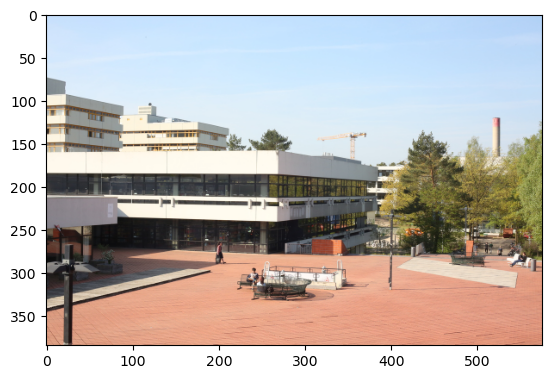

In [3]:
temp_img = image_data_list[0]['img']
plt.imshow(temp_img)

## extract feature for every image

In [4]:


temp_image_data_dicts = []
for image_data in image_data_list:
    new_image_data = computeFeatures(image_data)
    temp_image_data_dicts.append(new_image_data)
image_data_dicts = temp_image_data_dicts

found 512 ORB features on image 1
found 510 ORB features on image 2
found 515 ORB features on image 3
found 516 ORB features on image 4
found 510 ORB features on image 5
found 518 ORB features on image 6
found 516 ORB features on image 7
found 518 ORB features on image 8
found 513 ORB features on image 9


## knn feature matching

In [5]:

def matchknn2(descriptors1, descriptors2):
    """
    ## knn match ratio algorithm
    ## find first and second closest points in descriptors of feature points from to images
    ## return list of objects which contains all matched point pairs
    ## these objects could be defined by cv2.DMatch
    """

    ## Initialize an empty list of matches. (HINT: N x 2)
    knnmatches = []

    ## TODO 2.1
    ## Find the two nearest neighbors for every descriptor in image 1.
    n1, n2 = descriptors1.shape[0], descriptors2.shape[0]

    for i in range(n1):
        distances = list()
        for j in range(n2):
            # compute all distances of one to many points
            distances.append(cv2.norm(descriptors1[i], descriptors2[j], cv2.NORM_HAMMING))

        # sort results of distances
        sorted_j = np.argsort(distances)
        distances.sort()

        # define DMatch objects
        dm1 = cv2.DMatch(i, sorted_j[0], distances[0])
        dm2 = cv2.DMatch(i, sorted_j[1], distances[1])

        knnmatches.append([dm1, dm2])

        knnmatches = np.array(knnmatches).reshape(len(knnmatches), 2).tolist()


    return knnmatches



## filter with knn-ratio

In [6]:

def ratioTest(knnmatches, ratio_threshold):
    """
    ## TODO 2.2
    ## Compute the ratio between the nearest and second nearest neighbor.
    ## Add the nearest neighbor to the output matches if the ratio is smaller than ratio_threshold.
    """

    matches = []

    for i in range(len(knnmatches)):
        dis1 = knnmatches[i][0].distance
        dis2 = knnmatches[i][1].distance
        if dis1 / dis2 < ratio_threshold:
            matches.append(knnmatches[i][0])

    return matches


In [7]:
def computeMatches(img1, img2):
    knnmatches = matchknn2(img1['descriptors'], img2['descriptors'])
    matches = ratioTest(knnmatches, 0.7)
    print ("(" + str(img1['id']) + "," + str(img2['id']) + ") found " + str(len(matches)) + " matches.")
    return matches

## draw match image

In [8]:
def createMatchImage(img1, img2, matches):
    img_matches = cv2.drawMatches(img1['img'], img1['keypoints'], img2['img'], img2['keypoints'], matches,
               outImg=None, matchColor=(0, 255, 0), singlePointColor=(0, 255, 0), flags=2)
    return img_matches

In [5]:
img1 = temp_image_data_dicts[0]
img2 = temp_image_data_dicts[1]
img_matches = createMatchImage(img1, img2, computeMatches(img1, img2))
plt.imshow(img_matches)


## compute homograpy matrix

In [10]:

def computeHomography(points1, points2):
    """
    Compute a homography matrix from 4 point matches -- 8 points algorithm
    points1: [(1, 1), (3, 7), (2, -5), (10, 11)]
    points2: [(25, 156), (51, -83), (-144, 5), (345, 15)]
    """
    assert (len(points1) == 4)
    assert (len(points2) == 4)

    [(px1, py1), (px2, py2), (px3, py3), (px4, py4)] = points1
    [(qx1, qy1), (qx2, qy2), (qx3, qy3), (qx4, qy4)] = points2

    '''
    ## TODO 
    ## Construct A matrix used for linear least square estimation 
    '''

    A = [
        [-px1, -py1, -1, 0, 0, 0, px1 * qx1, py1 * qx1, qx1],
        [0, 0, 0, -px1, -py1, -1, px1 * qy1, py1 * qy1, qy1],
        [-px2, -py2, -1, 0, 0, 0, px2 * qx2, py2 * qx2, qx2],
        [0, 0, 0, -px2, -py2, -1, px2 * qy2, py2 * qy2, qy2],
        [-px3, -py3, -1, 0, 0, 0, px3 * qx3, py3 * qx3, qx3],
        [0, 0, 0, -px3, -py3, -1, px3 * qy3, py3 * qy3, qy3],
        [-px4, -py4, -1, 0, 0, 0, px4 * qx4, py4 * qx4, qx4],
        [0, 0, 0, -px4, -py4, -1, px4 * qy4, py4 * qy4, qy4]]

    # SVD
    U, s, V = np.linalg.svd(A, full_matrices=True)
    V = np.transpose(V)

    ## TODO 3
    ## - Extract the homogeneous solution of Ah=0 as the last column vector of V.
    ## - Store the result in H and Normalize H with h9

    H = V[:, 8].reshape((3, 3))
    H = H / H[2, 2]

    return H




## RANSAC 

In [11]:

def numInliers(points1, points2, H, threshold):

    """
    ## TODO 4.1
    ## Compute the number of inliers for the given homography and corresponding points
    ## Project the points from image 1 to image 2
    ## point is an inlier if the distance between the projected point and the point in image 2 is smaller than threshold
    ## Hint: Construct point 1 in Homogeneous coordinate before applying H.
    """

    InlierCount = 0
    n = len(points1)

    for i in range(n):

        q = list(points2[i])
        p = list(points1[i])

        # convert in homogeneous coordinate
        q.append(1)
        p.append(1)

        # project in 2nd img with given H
        p_ = np.dot(H, np.array(p))

        # normalize projected p
        p_ /= p_[2]

        # compute distance and compare with threshold
        dis = cv2.norm(np.array(q) - p_)
        if dis < threshold:
            InlierCount += 1

    return InlierCount


def computeHomographyRansac(img1, img2, matches, iterations, threshold):
    '''
    reduce outliers in matching by RANSAC Algorithm
    :param img1 & img2: input two images
    :param matches: retured list of matching points from knnmatch()
    :param iterations: iteration times
    :param threshold: threshold
    :return: the best result of Homography Matrix with the most inliers
    '''

    bestInlierCount = 0
    bestH = []
    # prepare data of matching points
    points1 = []
    points2 = []
    for i in range(len(matches)):
        points1.append(img1['keypoints'][matches[i].queryIdx].pt)
        points2.append(img2['keypoints'][matches[i].trainIdx].pt)

    for i in range(iterations):

        ## TODO 4.2
        ## Construct the subsets by randomly choosing 4 matches.
        subset1 = []
        subset2 = []
        for j in range(4):
            x = np.random.randint(0, len(points1) - 1)
            subset1.append(points1[x])
            subset2.append(points2[x])

        ## Compute the homography for this subset
        temp_H = computeHomography(subset1, subset2)

        ## Compute the number of inliers by applying H into all matching points but not subset
        temp_num = numInliers(points1, points2, temp_H, threshold=threshold)

        ## Keep track of the best homography (use the variables bestH and bestInlierCount)
        if bestInlierCount < temp_num:
            bestInlierCount = temp_num
            bestH = temp_H

    print ("(" + str(img1['id']) + "," + str(img2['id']) + ") found " + str(bestInlierCount) + " RANSAC inliers.")

    return bestH

## stitched image create

In [12]:

def computeHtoref(image_data_dir, center):
    for i in range(center - 1, -1, -1):
        c = image_data_dir[i]
        next_ = image_data_dir[i + 1]
        c['HtoReference'] = np.matmul(next_['HtoReference'], c['HtoNext'])

    for i in range(center + 1, len(image_data_dir), 1):
        c = image_data_dir[i]
        prev = image_data_dir[i - 1]
        c['HtoReference'] = np.matmul(prev['HtoReference'], c['HtoPrev'])

    return image_data_dir


def createStichedImage(image_data_dir):
    print("Stitching with "
          + str(len(image_data_dir)) +
          " images..")

    center = len(image_data_dir) // 2
    ref = image_data_dir[center]
    image_data_dir = computeHtoref(image_data_dir, center)

    print("Reference Image : " + str(center) + " - " + ref['file'])

    minx = 2353535
    maxx = -2353535
    miny = 2353535
    maxy = -2353535

    for i in range(len(image_data_dir)):
        img2 = image_data_dir[i]
        corners2 = [0, 0, 0, 0]
        corners2[0] = (0, 0)
        corners2[1] = (img2['img'].shape[1], 0)
        corners2[2] = (img2['img'].shape[1], img2['img'].shape[0])
        corners2[3] = (0, img2['img'].shape[0])
        corners2 = np.array(corners2, dtype='float32')
        corners2_in_1 = cv2.perspectiveTransform(corners2[None, :, :], img2['HtoReference'])

        for p in corners2_in_1[0]:
            minx = min(minx, p[0])
            maxx = max(maxx, p[0])
            miny = min(miny, p[1])
            maxy = max(maxy, p[1])

    roi = np.array([floor(minx), floor(miny), ceil(maxx) - floor(minx), ceil(maxy) - floor(miny)])
    print("ROI " + str(roi))

    ## Translate everything so the top left corner is at (0,0)
    ## Note: This can be simply done by adding the negavite offset to the
    ## homopgrahy
    offsetX = floor(minx);
    offsetY = floor(miny);
    ref['HtoReference'][0, 2] = -offsetX;
    ref['HtoReference'][1, 2] = -offsetY;
    computeHtoref(image_data_dir, center)

    cv2.namedWindow('Panorama')
    cv2.moveWindow('Panorama', 0, 500)

    stitchedImage = np.zeros([roi[3], roi[2], 3], dtype='uint8')
    for k in range(len(image_data_dir) + 1):
        if k % 2 == 0:
            tmp = 1
        else:
            tmp = -1
        i = center + tmp * ((k + 1) // 2)

        ## Out of index bounds check
        if (i < 0 or i >= len(image_data_dir)):
            continue

        ## Project the image onto the reference image plane
        img2 = image_data_dir[i]
        tmp = np.zeros([roi[3], roi[2], 3])

        rgba_img = cv2.cvtColor(img2['img'], cv2.COLOR_RGB2RGBA)
        rgba_img[:, :, 3] = 255

        tmp = cv2.warpPerspective(rgba_img, img2['HtoReference'], (tmp.shape[1], tmp.shape[0]), cv2.INTER_NEAREST)

        ## Added it to the output image
        for y in range(stitchedImage.shape[0]):
            for x in range(stitchedImage.shape[1]):
                if (tmp[y, x, 3] == 255 and np.array_equal(stitchedImage[y, x], np.array([0, 0, 0]))):
                    stitchedImage[y, x] = tmp[y, x, 0:3]

    return stitchedImage



In [13]:

for i in range(1, len(image_data_dicts)):
    matches = computeMatches(image_data_dicts[i - 1], image_data_dicts[i])

    ## Debug output
    matchImg = createMatchImage(image_data_dicts[i - 1], image_data_dicts[i], matches)
    h = 200
    w = int((float(matchImg.shape[1]) / matchImg.shape[0]) * h)
    matchImg = cv2.resize(matchImg, (w, h))
    name = "Matches (" + str(i - 1) + "," + str(i) + ") " + image_data_dicts[i - 1]['file'] + " - " + \
           image_data_dicts[i]['file']
    cv2.namedWindow(name)
    cv2.moveWindow(name, int(10 + w * ((i - 1) % 2)), int(10 + (h + 30) * ((i - 1) / 2)))
    cv2.imshow(name, matchImg)

    H = computeHomographyRansac(image_data_dicts[i - 1], image_data_dicts[i], matches, 1000, 2.0)
    image_data_dicts[i]['HtoPrev'] = np.linalg.inv(H)
    image_data_dicts[i - 1]['HtoNext'] = H



(1,2) found 250 matches.
(1,2) found 226 RANSAC inliers.
(2,3) found 261 matches.
(2,3) found 235 RANSAC inliers.
(3,4) found 220 matches.
(3,4) found 206 RANSAC inliers.
(4,5) found 244 matches.
(4,5) found 221 RANSAC inliers.
(5,6) found 237 matches.
(5,6) found 213 RANSAC inliers.
(6,7) found 245 matches.
(6,7) found 212 RANSAC inliers.
(7,8) found 246 matches.
(7,8) found 228 RANSAC inliers.
(8,9) found 241 matches.
(8,9) found 225 RANSAC inliers.


Stitching with 9 images..
Reference Image : 4 - 5.jpg
ROI [-427  -55 1386  482]


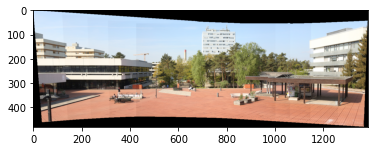

In [14]:
## =============== Stitching ==================
simg = createStichedImage(image_data_dicts)
plt.imshow(simg)